## 03 – Final evaluation and conclusion

### Telco Customer Churn – Final Evaluation and Conclusion

This notebook performs the final evaluation of the selected churn prediction model on the full dataset (or held‑out test set) and translates the results into clear business insights and next steps. It assumes the best model pipeline has already been trained and saved as `best_pipeline.pkl` in the previous notebook.

## 1. Import

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


## 2: Load data and model

### Setup: Data and Final Model

In this section:

- Load the cleaned Telco churn dataset (`telco_clean.csv`).  
- Recreate the feature matrix `X` and target vector `y`.  
- Load the saved **end‑to‑end pipeline** (`best_pipeline.pkl`) that includes preprocessing (encoders, scalers) and the tuned model.  

This mimics a real production scenario: raw‑like input features are passed directly into the pipeline to obtain churn predictions.

In [2]:
df = pd.read_csv("telco_clean.csv")

if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

y = df["Churn"].map({"No": 0, "Yes": 1})
X = df.drop(columns=["Churn"])

with open("best_pipeline.pkl", "rb") as f:
    best_model = pickle.load(f)

## 3: Final predictions

### Final Model Performance

Here the final model is evaluated using the complete evaluation set:

- **Accuracy** – overall fraction of correct predictions.  
- **Precision (churn)** – of the customers predicted as churners, how many actually churned. Important for controlling retention campaign cost.  
- **Recall (churn)** – of all real churners, how many the model correctly identified. This is the key metric for retention, because missed churners represent lost revenue.  
- **F1‑Score** – harmonic mean of precision and recall, useful when classes are imbalanced.  
- **ROC‑AUC** – measures how well the model ranks customers by churn risk across all thresholds.

A confusion matrix and classification report are also displayed to show the exact distribution of true positives, false positives, true negatives, and false negatives.

In [3]:
y_pred = best_model.predict(X)
y_prob = best_model.predict_proba(X)[:, 1]

acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
roc = roc_auc_score(y, y_prob)

print("Final Accuracy:", acc)
print("Final Precision:", prec)
print("Final Recall:", rec)
print("Final F1-Score:", f1)
print("Final ROC-AUC:", roc)
print("\nConfusion matrix:\n", confusion_matrix(y, y_pred))
print("\nClassification report:\n", classification_report(y, y_pred))

Final Accuracy: 0.7495733788395904
Final Precision: 0.5185185185185185
Final Recall: 0.8089887640449438
Final F1-Score: 0.631974921630094
Final ROC-AUC: 0.8474820892411921

Confusion matrix:
 [[3759 1404]
 [ 357 1512]]

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      5163
           1       0.52      0.81      0.63      1869

    accuracy                           0.75      7032
   macro avg       0.72      0.77      0.72      7032
weighted avg       0.81      0.75      0.76      7032



## 4: Confusion matrix heatmap

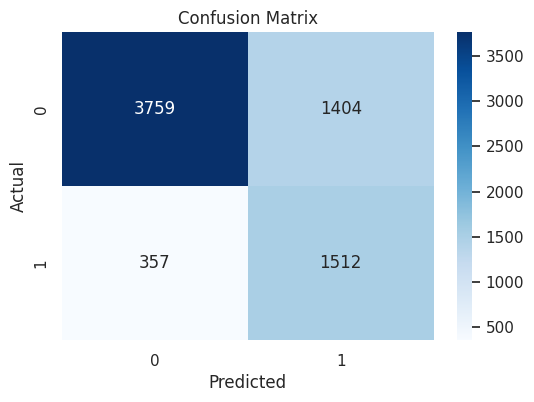

In [4]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 5: ROC curve

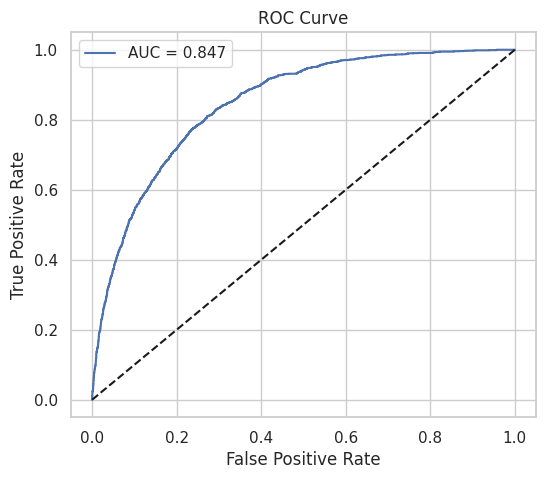

In [5]:
fpr, tpr, _ = roc_curve(y, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

## 6: Precision–Recall curve (optional but nice)

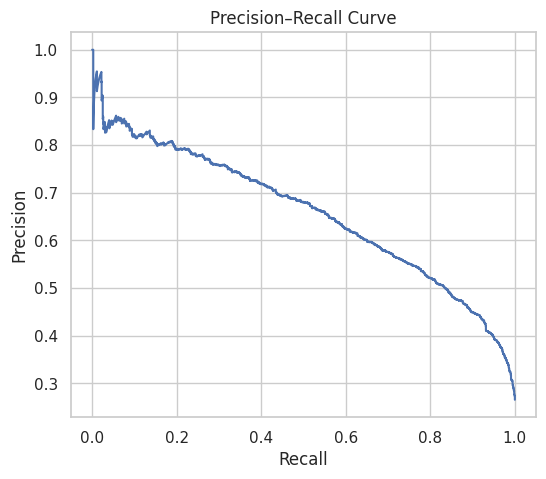

In [6]:
precisions, recalls, thresholds = precision_recall_curve(y, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()

## 7: Example of threshold tuning (business point)

In [10]:
threshold = 0.35  # choose after looking at PR curve

y_pred_custom = (y_prob >= threshold).astype(int)

print("=== With threshold =", threshold, "===")
print("Accuracy:", accuracy_score(y, y_pred_custom))
print("Precision:", precision_score(y, y_pred_custom))
print("Recall:", recall_score(y, y_pred_custom))
print("F1-Score:", f1_score(y, y_pred_custom))
print("Confusion matrix:\n", confusion_matrix(y, y_pred_custom))

=== With threshold = 0.35 ===
Accuracy: 0.675910125142207
Precision: 0.4461376773515502
Recall: 0.9085072231139647
F1-Score: 0.5984140969162995
Confusion matrix:
 [[3055 2108]
 [ 171 1698]]


## 8. Ready for Deployment

The final deliverable from this notebook is a **single serialized pipeline** (`best_pipeline.pkl`) that:

- Accepts raw‑like customer features as input (same schema as the original dataset).  
- Applies all preprocessing steps (encoding, scaling) consistently.  
- Outputs churn probability and class label.

This artifact can now be:

- Exposed via a **Flask or FastAPI service** for real‑time scoring.  
- Integrated into batch jobs to generate daily churn‑risk lists for retention teams.  
- Deployed in the cloud using Docker and a simple API layer.

This closes the modeling loop and prepares the churn prediction system for real‑world use in production.